In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv('../data/sample_sales.csv')

# Convert date
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Normalize column names
df.columns = df.columns.str.lower().str.strip()

# Use user_id as customer_id
df['customer_id'] = df['user_id']


In [2]:
# Create RFM Table
# Assume "today" is the day after the most recent order
today = df['date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'date': lambda x: (today - x.max()).days,       # Recency
    'order_id': 'nunique',                          # Frequency (distinct orders)
    'price': lambda x: (x * df.loc[x.index, 'quantity']).sum()  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

In [3]:
#Churn Detection using KMeans
# Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
rfm['churn_probability'] = kmeans.fit_predict(rfm_scaled)

# Assume the cluster with higher recency and lower frequency/monetary is churned
cluster_summary = rfm.groupby('churn_probability')[['recency', 'frequency', 'monetary']].mean()
churned_cluster = cluster_summary['recency'].idxmax()  # Higher recency = less recent purchase

rfm['churn_probability'] = (rfm['churn_probability'] == churned_cluster).astype(int)


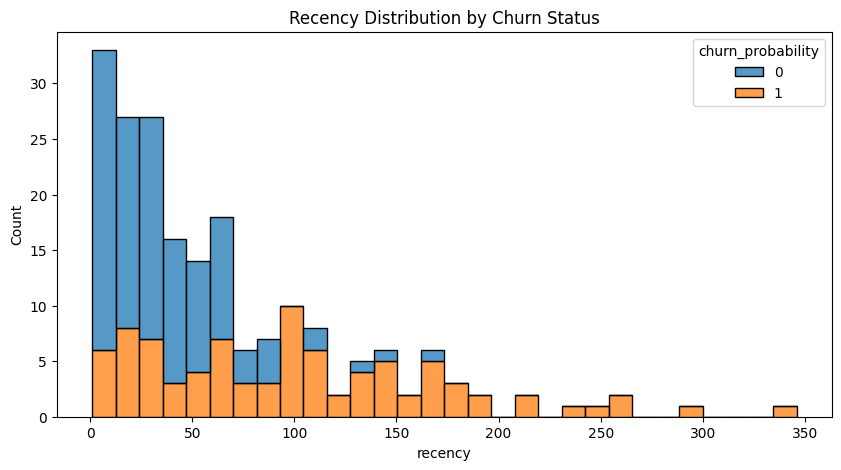

In [4]:
#Visualize Churn Patterns
plt.figure(figsize=(10,5))
sns.histplot(data=rfm, x='recency', hue='churn_probability', multiple='stack', bins=30)
plt.title("Recency Distribution by Churn Status")
plt.show()


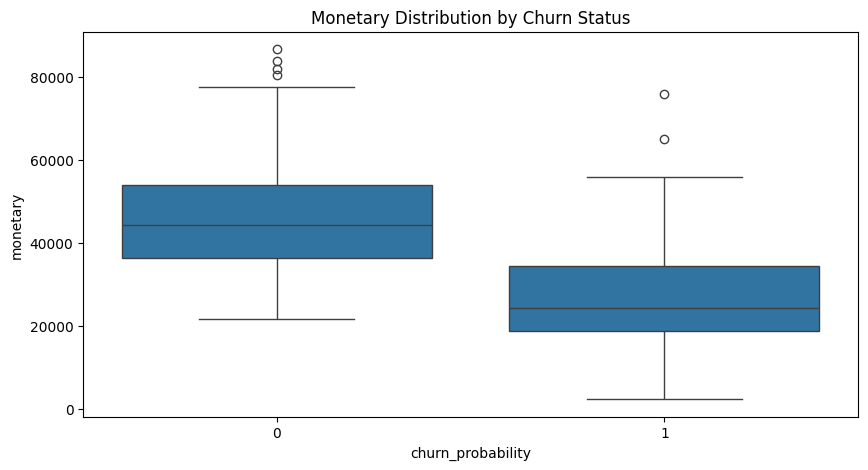

In [5]:
plt.figure(figsize=(10,5))
sns.boxplot(data=rfm, x='churn_probability', y='monetary')
plt.title("Monetary Distribution by Churn Status")
plt.show()


In [6]:
# Display Top At-Risk Customers
at_risk_customers = rfm[rfm['churn_probability'] == 1]
at_risk_customers = at_risk_customers.sort_values(by='monetary', ascending=False)

# Reset index for clean serial numbers
at_risk_customers = at_risk_customers.reset_index(drop=True)
at_risk_customers.index += 1  # Start serial number from 1

# Show top 10
print("Top 10 High-Risk Customers:")
print(at_risk_customers[['customer_id', 'recency', 'frequency', 'monetary', 'churn_probability']].head(10))



Top 10 High-Risk Customers:
   customer_id  recency  frequency  monetary  churn_probability
1        U0014      240          9  75938.34                  1
2        U0037      258          8  64929.43                  1
3        U0172      178         10  55995.53                  1
4        U0032      260         12  50694.45                  1
5        U0150       97          7  49774.24                  1
6        U0186      160         10  46641.45                  1
7        U0047      169          8  40893.61                  1
8        U0110      135         10  39834.75                  1
9        U0015      116         11  39289.25                  1
10       U0144       46          7  38396.56                  1


In [7]:
#Query for Loyal Customers
loyal_customers = rfm[(rfm['frequency'] >= rfm['frequency'].quantile(0.9)) & (rfm['recency'] < rfm['recency'].median())]

# Reset index for display
loyal_customers = loyal_customers.reset_index(drop=True)
loyal_customers.index += 1

print("Top Loyal Customers:")
print(loyal_customers[['customer_id', 'recency', 'frequency', 'monetary']])


Top Loyal Customers:
   customer_id  recency  frequency  monetary
1        U0012        5         15  71732.82
2        U0024       30         15  32717.55
3        U0027       41         14  40820.83
4        U0049        2         15  71991.15
5        U0076       42         15  57128.73
6        U0082       18         14  52586.46
7        U0085       13         16  43006.77
8        U0095       19         15  40336.61
9        U0102        1         15  41699.12
10       U0105       27         14  35821.53
11       U0108       23         14  30578.24
12       U0117       27         20  63687.97
13       U0147        6         17  47695.46
14       U0148       11         14  54859.49
15       U0161       16         14  38166.32
16       U0164        5         14  22804.79
17       U0174       35         19  57384.93
18       U0183        6         14  39706.55


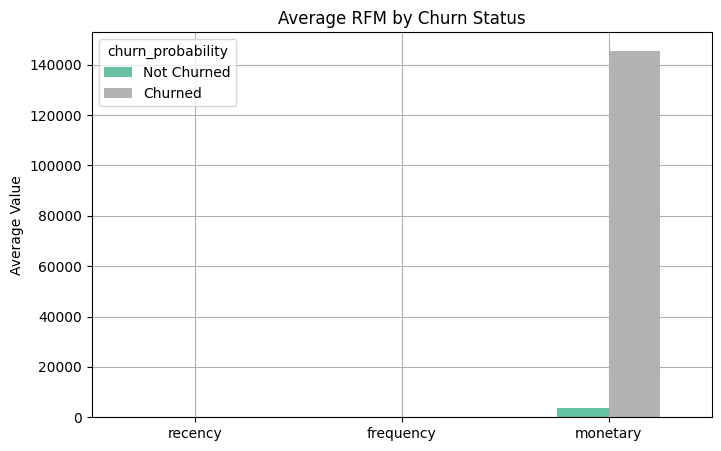

In [14]:
#Average RFM Comparison: Churned vs. Not Churned
rfm_avg = rfm.groupby('churn_probability')[['recency', 'frequency', 'monetary']].mean().rename(index={0: 'Not Churned', 1: 'Churned'})

# Bar chart
rfm_avg.T.plot(kind='bar', figsize=(8,5), title="Average RFM by Churn Status", colormap='Set2')
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.grid()
plt.show()


In [8]:
#Churn Rate Summary Table
# Churn summary
churn_summary = rfm['churn_probability'].value_counts(normalize=True).rename({0: 'Active', 1: 'Churned'}) * 100
churn_summary_df = churn_summary.reset_index().rename(columns={'index': 'Status', 'churn_probability': 'Percentage'})

print("📉 Churn Rate Summary")
print(churn_summary_df)


📉 Churn Rate Summary
  Percentage  proportion
0     Active        56.0
1    Churned        44.0


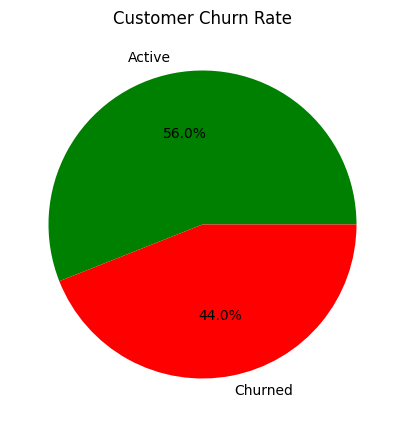

In [9]:
plt.figure(figsize=(5,5))
churn_summary.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])
plt.title("Customer Churn Rate")
plt.ylabel("")
plt.show()


In [10]:
#High-Value At-Risk Customers
high_value_churn = rfm[(rfm['churn_probability'] == 1) & 
                       (rfm['monetary'] >= rfm['monetary'].median())]

print("🧨 High-Value At-Risk Customers")
print(high_value_churn[['customer_id', 'recency', 'frequency', 'monetary']].sort_values(by='monetary', ascending=False).head(10))


🧨 High-Value At-Risk Customers
    customer_id  recency  frequency  monetary
13        U0014      240          9  75938.34
36        U0037      258          8  64929.43
171       U0172      178         10  55995.53
31        U0032      260         12  50694.45
149       U0150       97          7  49774.24
185       U0186      160         10  46641.45
46        U0047      169          8  40893.61
109       U0110      135         10  39834.75
14        U0015      116         11  39289.25
143       U0144       46          7  38396.56


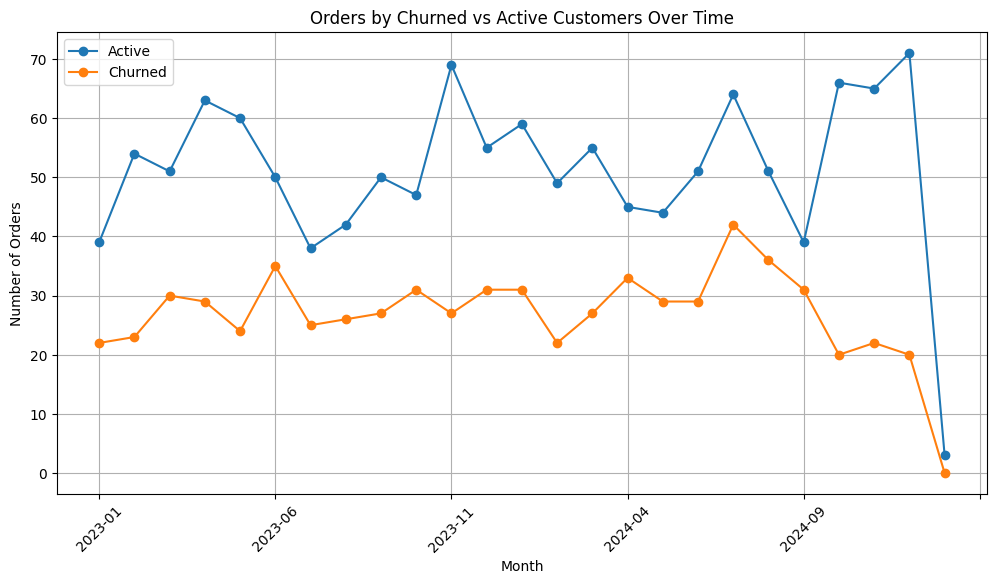

In [11]:
#Timeline Trend: Churned vs Active Over Time (optional)
df['date'] = pd.to_datetime(df['date'])
df = df.merge(rfm[['customer_id', 'churn_probability']], on='customer_id')

# Group by month
df['month'] = df['date'].dt.to_period('M').astype(str)
monthly_churn = df.groupby(['month', 'churn_probability'])['order_id'].nunique().reset_index()
monthly_churn_pivot = monthly_churn.pivot(index='month', columns='churn_probability', values='order_id').fillna(0)
monthly_churn_pivot.columns = ['Active', 'Churned']

# Plot
monthly_churn_pivot.plot(kind='line', figsize=(12, 6), marker='o')
plt.title("Orders by Churned vs Active Customers Over Time")
plt.ylabel("Number of Orders")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.show()
